In [1]:
# libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Epydemix import
from epydemix.population import Population
from epydemix.epimodel import EpiModel
from epydemix.plotting import plot_quantiles

# Population Object

In [2]:
population = Population(name="Indonesia")

# add contact matrices
population.add_contact_matrix(np.load("./basins/Indonesia/contacts-matrix/contacts_matrix_work.npz")["arr_0"], 
                              layer_name="work")
population.add_contact_matrix(np.load("./basins/Indonesia/contacts-matrix/contacts_matrix_home.npz")["arr_0"], 
                              layer_name="home")
population.add_contact_matrix(np.load("./basins/Indonesia/contacts-matrix/contacts_matrix_community.npz")["arr_0"], 
                              layer_name="community")
population.add_contact_matrix(np.load("./basins/Indonesia/contacts-matrix/contacts_matrix_school.npz")["arr_0"], 
                              layer_name="school")

# add population in different age groups
population.add_population(Nk=pd.read_csv("./basins/Indonesia/demographic/Nk.csv")["value"].values, 
                          Nk_names=pd.read_csv("./basins/Indonesia/demographic/Nk.csv")["group"].values)

# EpiModel Object

In [3]:
# create model 
model = EpiModel(compartments=["S", "I"])

# add compartments
model.add_compartments("R")

# add transitions 
model.add_transition(source="S", target="I", rate=0.04, rate_name="beta", agent="I")
model.add_transition(source="I", target="R", rate=0.1, rate_name="mu")

# add interventions
model.add_intervention(layer_name="work", start_date="2020-01-01", end_date="2020-05-01", reduction_factor=0.3)
#model.add_intervention(layer_name="school", start_date="2020-01-01", end_date="2020-02-01", new_matrix=population.contact_matrices["community"])


In [4]:
compartments, df_quantiles = model.simulate(population=population, 
                              start_date="2019-12-01", 
                              end_date="2020-06-01", 
                              S=population.Nk - np.ones(len(population.Nk)),
                              I=np.ones(len(population.Nk)),
                              R=np.zeros(len(population.Nk)),
                              steps=100)

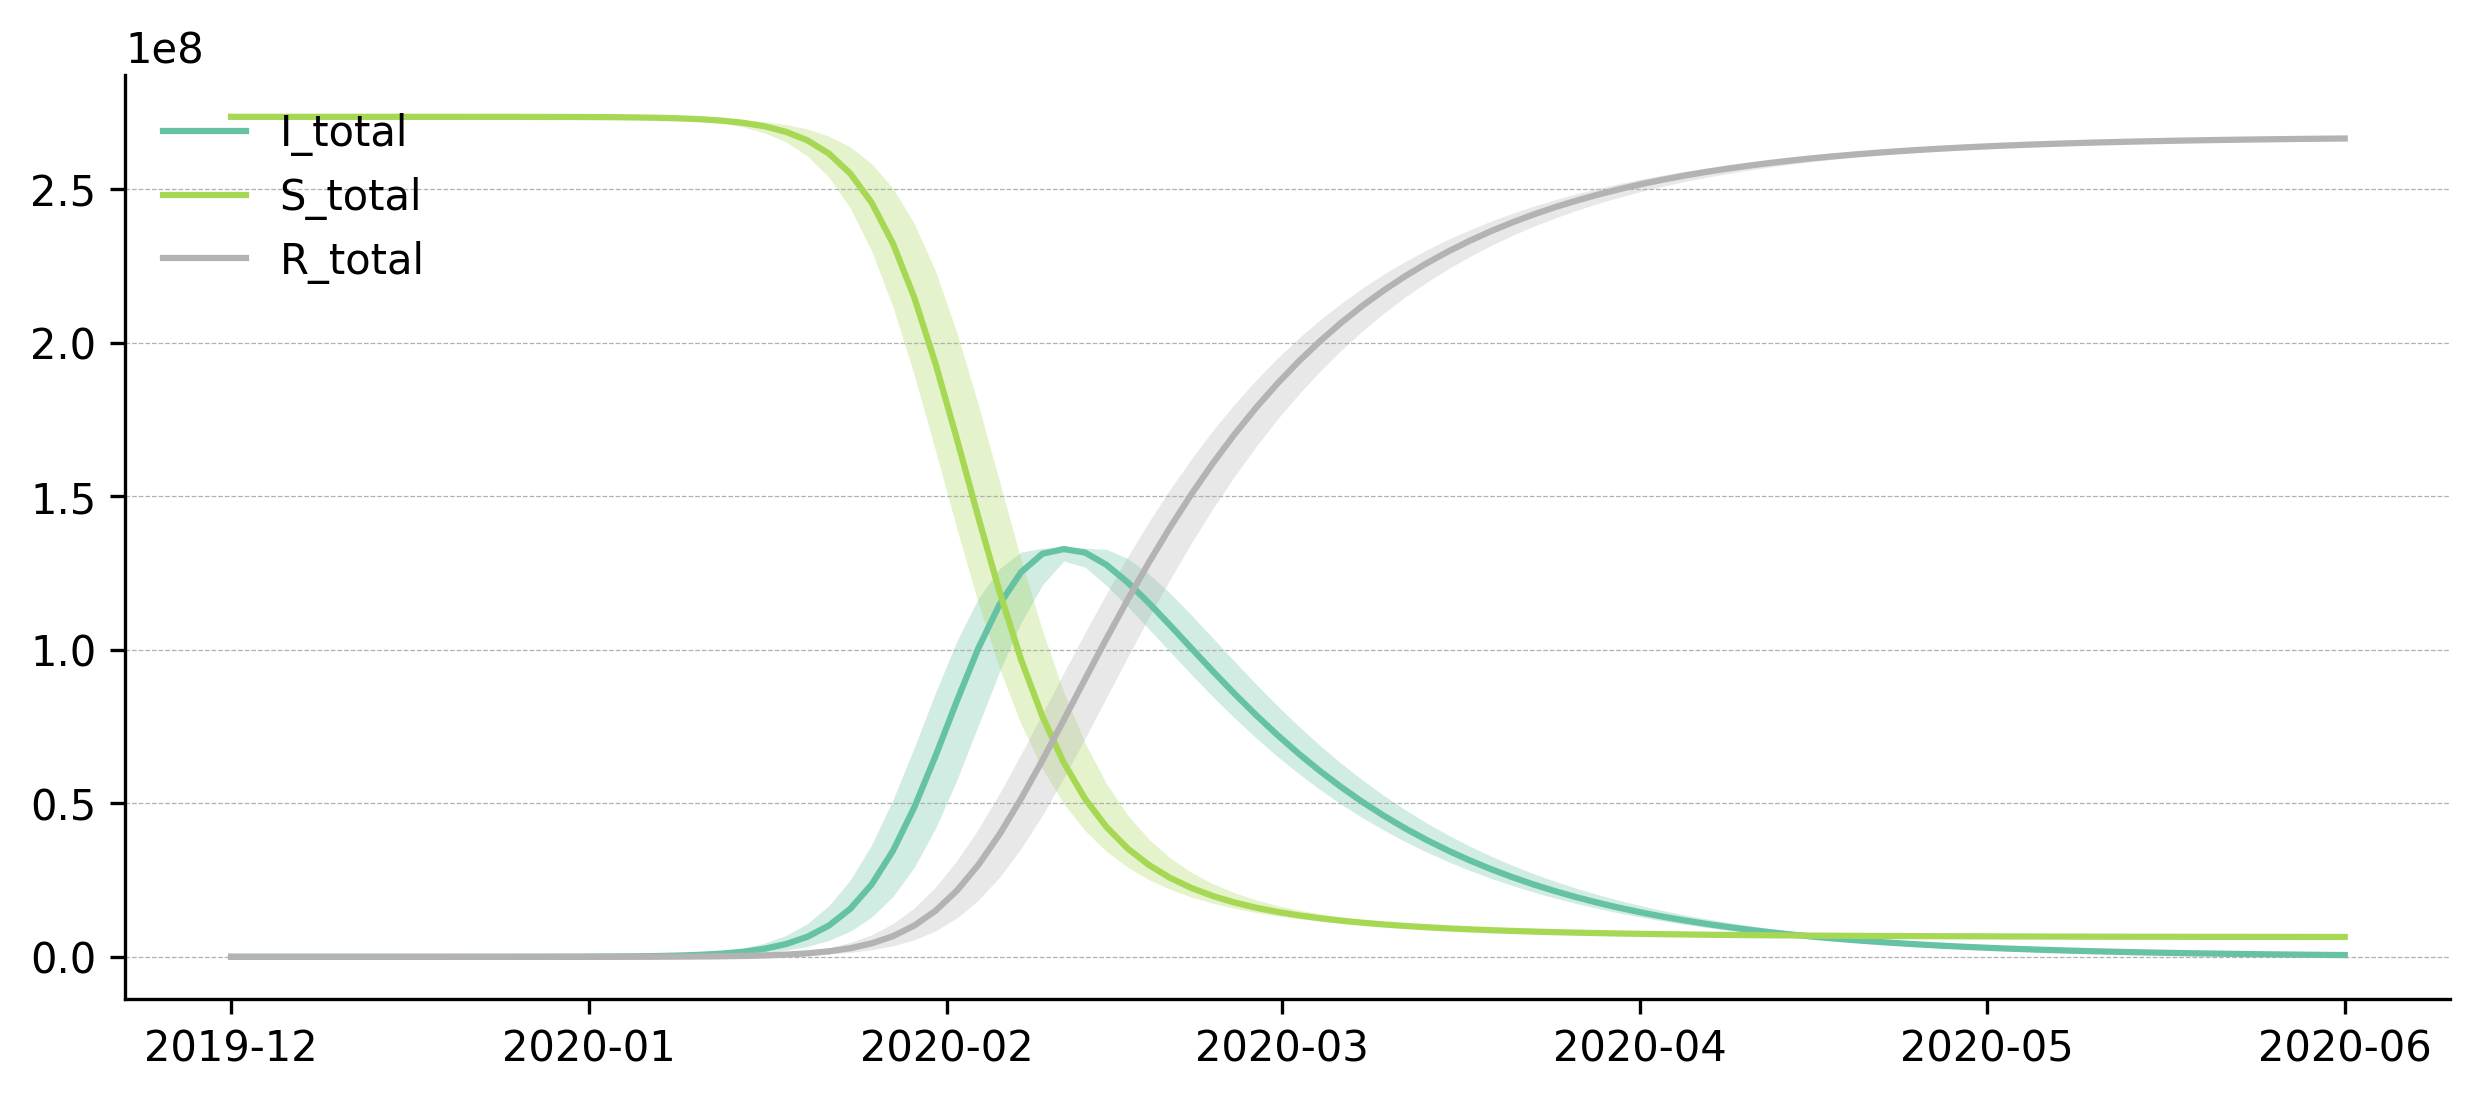

In [7]:
plot_quantiles(df_quantiles, compartments=["I", "S", "R"], demographic_groups="total")
